In [226]:
import pandas as pd
import numpy as np
import warnings

# Ignore warnings
warnings.filterwarnings("ignore")

# Load Data
traffic_df = pd.read_csv('agg_data/hits.csv')
traffic_df.head()

,fullVisitorId,date,visitNumber,weekday,transactions,transactionRevenue,hits,pageViews,source,medium,continent,country,browser,operatingSystem,deviceCategory,secondsSpent,hourOfDay,eventCount,productsBrowsed
0,10278554503158,2016-10-20,1,Thursday,NaN,NaN,11,8.0,google,organic,Oceania,New Zealand,Chrome,Macintosh,desktop,194.103,22,3,NaN
1,20424342248747,2016-11-30,1,Wednesday,NaN,NaN,17,13.0,(direct),(none),Americas,Peru,Chrome,Windows,desktop,297.323,23,4,Men's Apparel
2,27376579751715,2017-02-11,1,Saturday,NaN,NaN,6,5.0,(direct),(none),Americas,United States,Chrome,Macintosh,desktop,49.413,18,1,NaN
3,39460501403861,2017-03-27,1,Monday,NaN,NaN,2,2.0,youtube.com,referral,Americas,Brazil,Chrome,Windows,desktop,99.020,8,0,NaN
4,40862739425590,2017-02-11,1,Saturday,NaN,NaN,2,2.0,(direct),(none),Americas,United States,Chrome,Macintosh,desktop,14.079,10,0,Page Unavailable


**Note: the dataset only included the records where the user first converted and hasn't converted within 2016-08 till 2017-08.**

# Exploratory Data Analysis

In [227]:
traffic_df['transactions'].unique()

array([nan,  1.,  2.,  3.,  4.,  5.,  6., 10.,  8., 21., 25.,  7., 12.,
       15.])

In [228]:
traffic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 903653 entries, 0 to 903652
Data columns (total 19 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   fullVisitorId       903653 non-null  object 
 1   date                903653 non-null  object 
 2   visitNumber         903653 non-null  int64  
 3   weekday             903653 non-null  object 
 4   transactions        11552 non-null   float64
 5   transactionRevenue  11515 non-null   float64
 6   hits                903653 non-null  int64  
 7   pageViews           903553 non-null  float64
 8   source              903653 non-null  object 
 9   medium              903653 non-null  object 
 10  continent           903653 non-null  object 
 11  country             903653 non-null  object 
 12  browser             903653 non-null  object 
 13  operatingSystem     903653 non-null  object 
 14  deviceCategory      903653 non-null  object 
 15  secondsSpent        903653 non-nul

The word cloud for medium has referral as the main medium, but looking at the sources, Partners and dfa contribute much less than direct and google. This indicates that some customers might have click off the site and re-entered them directly after some time.

In [229]:
traffic_df['medium'].value_counts()

medium
(none)       371467
referral     262022
organic      234381
affiliate     16403
cpc           13079
cpm            6184
(not set)       117
Name: count, dtype: int64

The medium displayed above are explained in the following based on Google Analytics:

- cpc (Cost Per Click):	Paid search traffic where you pay per click (Google Ads, Bing Ads).
- organic:	Free search engine traffic (Google, Bing, etc.).
- referral:	Traffic from another website linking to yours.
- affiliate: Traffic from an affiliate marketing partner.
- cpm (Cost Per Mille): Paid traffic from display ads where you pay per 1,000 impressions, not per click (Youtube, Facebook, etc.).
- (none): No medium was used (direct or lost assesses to the site).
- (not set): unknown.

Referenced from [here](https://measureschool.com/source-medium-google-analytics/).

In [230]:
# Check whether all '(none)' medium has the source '(direct)', vice versa
print(traffic_df.loc[traffic_df['medium'] == '(none)', 'source'].value_counts())
print(traffic_df.loc[traffic_df['source'] == '(direct)', 'medium'].value_counts())

source
(direct)    371467
Name: count, dtype: int64
medium
(none)    371467
cpm            2
Name: count, dtype: int64


All direct source refers to the '(none)' medium except for two from 'cpm' medium, which violates the definition of mediums and source and they will be removed. Furthermore, it seems 'isTrueDirect' is Google Analytics' indicator to whether the user assessed the website directly during their visit.

In [231]:
# Drop direct cpm instances
traffic_df = traffic_df.loc[~((traffic_df['source'] == '(direct)') & (traffic_df['medium'] == 'cpm'))]

In [232]:
# Redefine the medium column based on their definitions
map_dictionary = {'organic': 'Search', '(none)': 'Direct', 
                  'referral': 'Referral', 'cpc':'Paid Search', 
                  'affiliate': 'Affiliate', 'cpm': 'Display Ad', '(not set)': 'Unknown'}

traffic_df['medium'] = traffic_df['medium'].map(map_dictionary)

# the number of visits by medium in percentage
traffic_df['medium'].value_counts().div(len(traffic_df)).mul(100).round(2)

medium
Direct         41.11
Referral       29.00
Search         25.94
Affiliate       1.82
Paid Search     1.45
Display Ad      0.68
Unknown         0.01
Name: count, dtype: float64

In [233]:
# Look at the revenue generated by each medium
traffic_df.groupby(['medium'])['transactionRevenue'].sum().div(1e9).sort_values(ascending=False)

medium
Direct         1190.17511
Search          204.88905
Display Ad       78.26819
Referral         40.95476
Paid Search      25.17676
Affiliate         0.59738
Unknown           0.00999
Name: transactionRevenue, dtype: float64

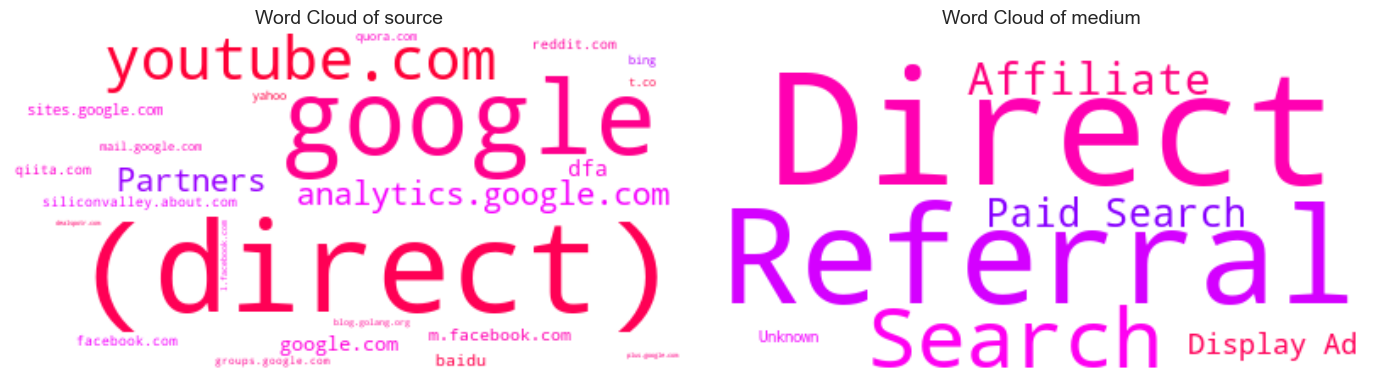

In [234]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import random

# Rainbow Coloring Function
def rainbow_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    hue = random.randint(270, 350)  # Random hue for rainbow effect
    return f"hsl({hue}, 100%, 50%)"  # Full saturation and medium brightness for vibrant colors

# Create the figure and subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))  # 1 row, 2 columns

for i, col in enumerate(['source', 'medium']):
    # Count unique words
    word_counts = Counter(traffic_df[col].tolist())

    # Generate WordCloud using frequency dictionary
    wordcloud = WordCloud(max_words=30, background_color="white").generate_from_frequencies(word_counts)

    # Plot in subplot
    axes[i].imshow(wordcloud.recolor(color_func=rainbow_color_func, random_state=3), interpolation='bilinear')
    axes[i].set_title(f'Word Cloud of {col}', fontsize=14)
    axes[i].axis("off")  # Hide axes

# Adjust layout
plt.tight_layout()
plt.show()

# Save the figure
fig.savefig('wordclouds.svg')

The unknown visits has genenrated the lowest revenue compared to all others. We decided to remove these visits given its numbers and low impact.

In [235]:
# Drop all Unknow visits
traffic_df = traffic_df.loc[traffic_df['medium'] != 'Unknown']

## Conversion Rate by Medium

Look at the pathway the users took, or the pathway customers took before their conversion.

In [236]:
# check fullVisitorId count
count = traffic_df['fullVisitorId'].value_counts(ascending = False)

print("Between 2016-08-01 to 2017-07-31, there are %s distinct visitor IDs, and %s total records." % (len(count),len(traffic_df), ))

Between 2016-08-01 to 2017-07-31, there are 714146 distinct visitor IDs, and 903534 total records.


In [237]:
# Conversion rates
conversion_rate = traffic_df['transactions'].sum() / len(traffic_df)
conversion_rate

0.01340735379078153

In [238]:
# Fill NaN values with 0
traffic_df['transactions'] = traffic_df['transactions'].fillna(0)
traffic_df['transactionRevenue'] = traffic_df['transactionRevenue'].fillna(0)

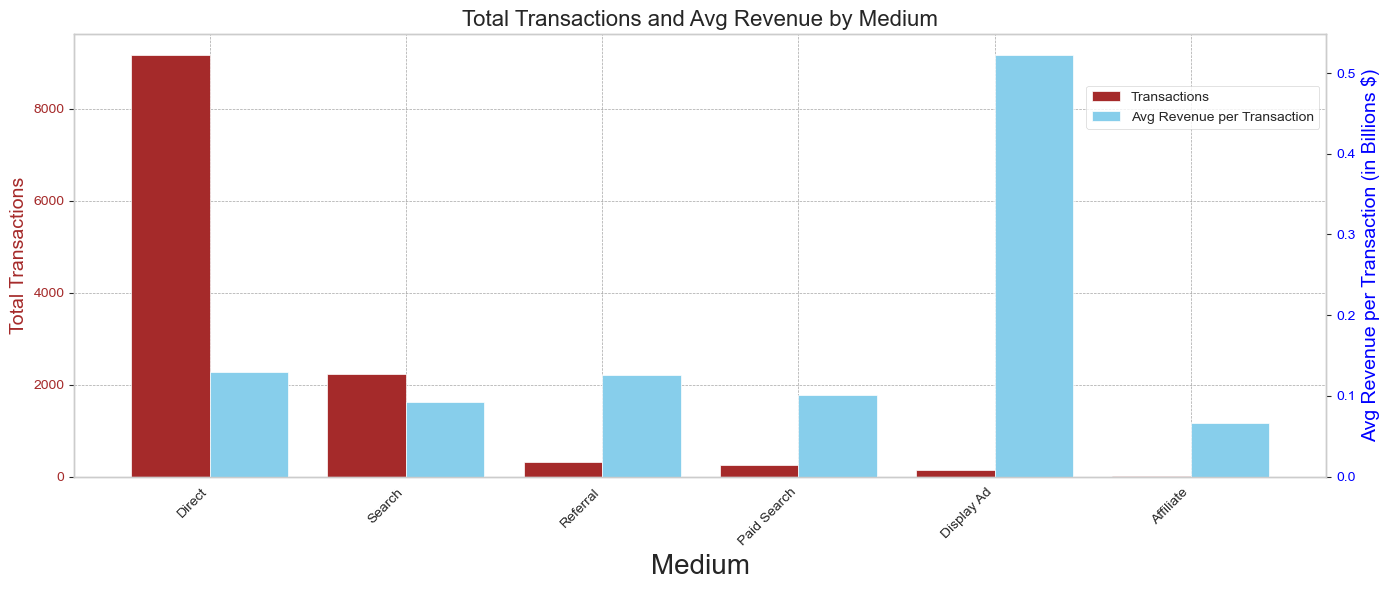

In [254]:
# Summarize data by medium
mediums = traffic_df['medium'].unique()  # Unique medium names
total_revenue_by_medium = traffic_df.groupby(['medium'])['transactionRevenue'].sum().div(1e9)  # Convert to billions
total_transactions_by_medium = traffic_df.groupby(['medium'])['transactions'].sum()

# Calculate average revenue per transaction
average_revenue_per_transaction = (total_revenue_by_medium / total_transactions_by_medium).fillna(0)  # Avoid division by zero

# Sort datasets by total transactions (you can change this to average revenue if needed)
sorted_mediums = total_transactions_by_medium.sort_values(ascending=False).index
total_transactions_by_medium = total_transactions_by_medium[sorted_mediums]
average_revenue_per_transaction = average_revenue_per_transaction[sorted_mediums]

# Bar positions and width
x = np.arange(len(sorted_mediums))  # Position of each bar group
bar_width = 0.4  # Width of each bar

# Create the figure and axis
fig, ax1 = plt.subplots(figsize=(14, 6))

# Plot the transaction bars (left y-axis)
bars1 = ax1.bar(x - bar_width / 2, total_transactions_by_medium, bar_width, label='Transactions', color='brown')
ax1.set_xlabel('Medium', fontsize=20)
ax1.set_ylabel('Total Transactions', fontsize=14, color='brown')
ax1.tick_params(axis='y', labelcolor='brown')
ax1.set_title('Total Transactions and Avg Revenue by Medium', fontsize=16)
ax1.set_xticks(x)
ax1.set_xticklabels(sorted_mediums, rotation=45, ha='right')

# Enable grid on the primary axis
ax1.grid(True, which='both', linestyle='--', linewidth=0.5, color='gray', alpha=0.7)

# Create a second y-axis
ax2 = ax1.twinx()
bars2 = ax2.bar(x + bar_width / 2, average_revenue_per_transaction, bar_width, label='Avg Revenue per Transaction', color='skyblue')
ax2.set_ylabel('Avg Revenue per Transaction (in Billions $)', fontsize=14, color='blue')
ax2.tick_params(axis='y', labelcolor='blue')

# Ensure both axes share the same grid
ax2.grid(False)  # Disable the grid for the secondary axis to avoid duplication

# Add a legend
fig.legend(loc='upper right', bbox_to_anchor=(1, 0.9), bbox_transform=ax1.transAxes)

# Save the figure to a file
fig.savefig('transactions_avg_revenue_by_medium.svg')  # Save as an SVG file

# Adjust layout and show plot
plt.tight_layout()
plt.show()

## Multitouch Attirbution

Now, the relationship between medium should be looked into, Markov models in channel attribution package [ChannelAttribution](https://github.com/DavideAltomare/ChannelAttribution).

In [240]:
# Compile the journey of each visitor
path_df = traffic_df.groupby('fullVisitorId').agg(
    path = ('medium', lambda x: x.tolist())
).reset_index()

In [241]:
# Check path variable
path_df['path_count'] = path_df['path'].apply(len)
path_df = path_df.sort_values('path_count', ascending = False)
path_df.head()

,fullVisitorId,path,path_count
191239,1957458976293878100,"[Search, Search, Search, Search, Search, Searc...",278
106777,824839726118485274,"[Search, Search, Search, Search, Search, Searc...",255
635158,3608475193341679870,"[Paid Search, Paid Search, Paid Search, Paid S...",201
184611,1856749147915772585,"[Search, Search, Search, Search, Search, Searc...",199
274524,3269834865385146569,"[Direct, Direct, Direct, Direct, Direct, Direc...",155


In [242]:
#Looking at the last interaction to see if it led to a user converting
last_interaction_df = traffic_df.drop_duplicates('fullVisitorId', keep='last')[['fullVisitorId', 'transactions', 'transactionRevenue']]
last_interaction_df.head()

,fullVisitorId,transactions,transactionRevenue
0,10278554503158,0.0,0.0
1,20424342248747,0.0,0.0
2,27376579751715,0.0,0.0
3,39460501403861,0.0,0.0
5,40862739425590,0.0,0.0


In [243]:
#Concatinating with the dataframes of user path's
path_df = pd.merge(path_df, last_interaction_df, how='left', on='fullVisitorId')
path_df.head()

,fullVisitorId,path,path_count,transactions,transactionRevenue
0,1957458976293878100,"[Search, Search, Search, Search, Search, Searc...",278,0.0,0.0
1,824839726118485274,"[Search, Search, Search, Search, Search, Searc...",255,0.0,0.0
2,3608475193341679870,"[Paid Search, Paid Search, Paid Search, Paid S...",201,0.0,0.0
3,1856749147915772585,"[Search, Search, Search, Search, Search, Searc...",199,0.0,0.0
4,3269834865385146569,"[Direct, Direct, Direct, Direct, Direct, Direc...",155,0.0,0.0


In [244]:
#We will create a variable ‘path’ in the specific formatrequired by the Attribution Model where the ordered channels a user interacts with are delimited by'>'
path_df['path'] = path_df['path'].apply(lambda x : ' > '.join(x) if len(x) > 1 else x[0])
path_df

,fullVisitorId,path,path_count,transactions,transactionRevenue
0,1957458976293878100,Search > Search > Search > Search > Search > S...,278,0.0,0.0
1,824839726118485274,Search > Search > Search > Search > Search > S...,255,0.0,0.0
2,3608475193341679870,Paid Search > Paid Search > Paid Search > Paid...,201,0.0,0.0
3,1856749147915772585,Search > Search > Search > Search > Search > S...,199,0.0,0.0
4,3269834865385146569,Direct > Direct > Direct > Direct > Direct > D...,155,0.0,0.0
...,...,...,...,...,...
714141,2954754310351497342,Direct,1,0.0,0.0
714142,2954773003061903164,Referral,1,0.0,0.0
714143,2954803096853253888,Search,1,0.0,0.0
714144,2954811050492275840,Direct,1,0.0,0.0


In [245]:
#Removing the vistor's ID and grouping by the path to see the how many times a specific combination of channels led to a conversion or null outcome
path_df.drop(['fullVisitorId', 'path_count'], axis = 1, inplace = True)
path_df['null'] = np.where(path_df['transactions'] == 0,1,0)

attribution_df = path_df.groupby('path', as_index = False).sum()
attribution_df.rename(columns={"transactions": "total_conversions", "null": "total_null", "transactionRevenue": "total_conversion_value"}, inplace = True)
attribution_df.sample(10)

,path,total_conversions,total_conversion_value,total_null
2629,Search > Search > Search > Referral > Search >...,0.0,0.0,1
2101,Search > Direct > Direct > Search > Direct > D...,0.0,0.0,1
280,Direct > Direct > Direct > Direct > Direct > D...,0.0,0.0,1
656,Direct > Direct > Direct > Paid Search,2.0,675450000.0,18
1592,Paid Search > Paid Search > Paid Search > Dire...,0.0,0.0,1
1418,Display Ad > Direct > Direct > Direct > Direct...,0.0,0.0,1
1695,Paid Search > Search > Search > Direct > Search,0.0,0.0,1
329,Direct > Direct > Direct > Direct > Direct > D...,0.0,0.0,1
1714,Referral > Affiliate > Affiliate > Affiliate >...,0.0,0.0,1
1263,Direct > Search > Direct > Direct > Direct > D...,0.0,0.0,1


In [246]:
from ChannelAttribution import *

#Heuristic models
H=heuristic_models(attribution_df,"path","total_conversions",var_value="total_conversion_value")
H


*** Looking to run more advanced attribution? Try ChannelAttribution Pro for free! Visit https://channelattribution.io/product


,channel_name,first_touch_conversions,first_touch_value,last_touch_conversions,last_touch_value,linear_touch_conversions,linear_touch_value
0,Affiliate,7.0,3.340900e+08,6.0,3.018100e+08,6.666667,3.317683e+08
1,Referral,124.0,8.871840e+09,159.0,1.180138e+10,143.542196,1.019369e+10
2,Direct,4936.0,4.586069e+11,4931.0,4.542341e+11,4922.776605,4.578056e+11
3,Search,1253.0,1.023801e+11,1253.0,9.993690e+10,1255.357360,9.994208e+10
4,Paid Search,133.0,9.266740e+09,125.0,1.137385e+10,131.491631,1.003006e+10
5,Display Ad,86.0,8.562440e+09,65.0,1.037398e+10,79.165541,9.718809e+09


In [247]:
#Markov Models
M=markov_model(attribution_df, "path", "total_conversions", var_value="total_conversion_value")
M.sort_values(by = "total_conversion_value", ascending = False)

Number of simulations: 100000 - Convergence reached: 1.84% < 5.00%
Percentage of simulated paths that successfully end before maximum number of steps (9) is reached: 99.99%
*** Looking to run more advanced attribution? Try ChannelAttribution Pro for free! Visit https://channelattribution.io/product


,channel_name,total_conversions,total_conversion_value
1,Direct,4691.757744,4.291852e+11
2,Search,1358.406122,1.100355e+11
5,Display Ad,119.981651,1.898216e+10
4,Paid Search,178.190571,1.554079e+10
3,Referral,183.536288,1.400824e+10
0,Affiliate,7.127623,2.702462e+08


In [248]:
import plotly.io as pio

# Visualize results
R=pd.merge(H,M,on="channel_name",how="inner")
R1=R[["channel_name","first_touch_conversions","last_touch_conversions",\
"linear_touch_conversions","total_conversions"]]
R1.columns=["channel_name","first_touch","last_touch","linear_touch","markov_model"]

R1=pd.melt(R1, id_vars="channel_name")

result = [dict(
    type = "histogram", 
    histfunc="sum",
    x = R1.channel_name, 
    y = R1.value,
    # Round summed values to integers using a custom text template
    hovertemplate="<b>%{x}</b><br>Conversions: <b>%{y:,.0f}</b><extra></extra>",
    transforms = [dict(type = "groupby", groups = R1.variable,)],
)]

# Create layout with axis labels and title
layout = dict(
    title="Attribution Models Comparison",
    xaxis=dict(title="Sources"),
    yaxis=dict(
        title="Conversions"),
    barmode='group'  # This groups the bars side by side for better comparison
)

fig = dict({"data":result, "layout":layout}) 
pio.show(fig,validate=False)

# Table for Value/Conversion ratio
for col in R.columns:
    if "_value" in col:
        base_name = col.replace("_value", "")
        rate_col = base_name + "_rate"

        if base_name == 'total_conversion':
            R[rate_col] = R[col] / R[base_name + "s"]
            continue
        R[rate_col] = R[col] / R[base_name + "_conversions"]

# Display the resulting DataFrame
R[["channel_name"] + [col for col in R.columns if "_rate" in col]].sort_values(by = "total_conversion_rate", ascending = False)

,channel_name,first_touch_rate,last_touch_rate,linear_touch_rate,total_conversion_rate
5,Display Ad,9.956326e+07,1.595997e+08,1.227656e+08,1.582088e+08
2,Direct,9.291063e+07,9.211806e+07,9.299745e+07,9.147641e+07
4,Paid Search,6.967474e+07,9.099080e+07,7.627904e+07,8.721444e+07
3,Search,8.170796e+07,7.975810e+07,7.961246e+07,8.100336e+07
1,Referral,7.154710e+07,7.422252e+07,7.101526e+07,7.632411e+07
0,Affiliate,4.772714e+07,5.030167e+07,4.976525e+07,3.791533e+07


All model suggest Direct and Search is most important in conversion and closing sales, whether it is conversion at first touch, last touch, or by markov chain analysis, likely due to returning visitors assessing the link with search engine or saved link to the website.

The rate for display advertisement is the highest, but the number of conversions from display advertisements is less than 2\% of the direct visits, hence the revenue generate from display advertisement is much less frequent than direct visits within a year.

In [249]:
# Markov chain transition matrix
transition_matrix = transition_matrix(attribution_df, "path", "total_conversions", var_null="total_null")

matrix = transition_matrix['transition_matrix']
matrix = pd.pivot_table(matrix, values='transition_probability', index=['channel_from'],
                    columns=['channel_to'], aggfunc=np.sum)

column_dict = transition_matrix['channels'].set_index('id_channel')['channel_name'].to_dict()
keys_values = column_dict.items()
column_dict = {str(key): str(value) for key, value in keys_values}

matrix = matrix.rename(mapper=column_dict, axis=1).rename(mapper=column_dict, axis=0)
matrix.fillna(0, inplace = True)

*** Looking to run more advanced attribution? Try ChannelAttribution Pro for free! Visit https://channelattribution.io/product


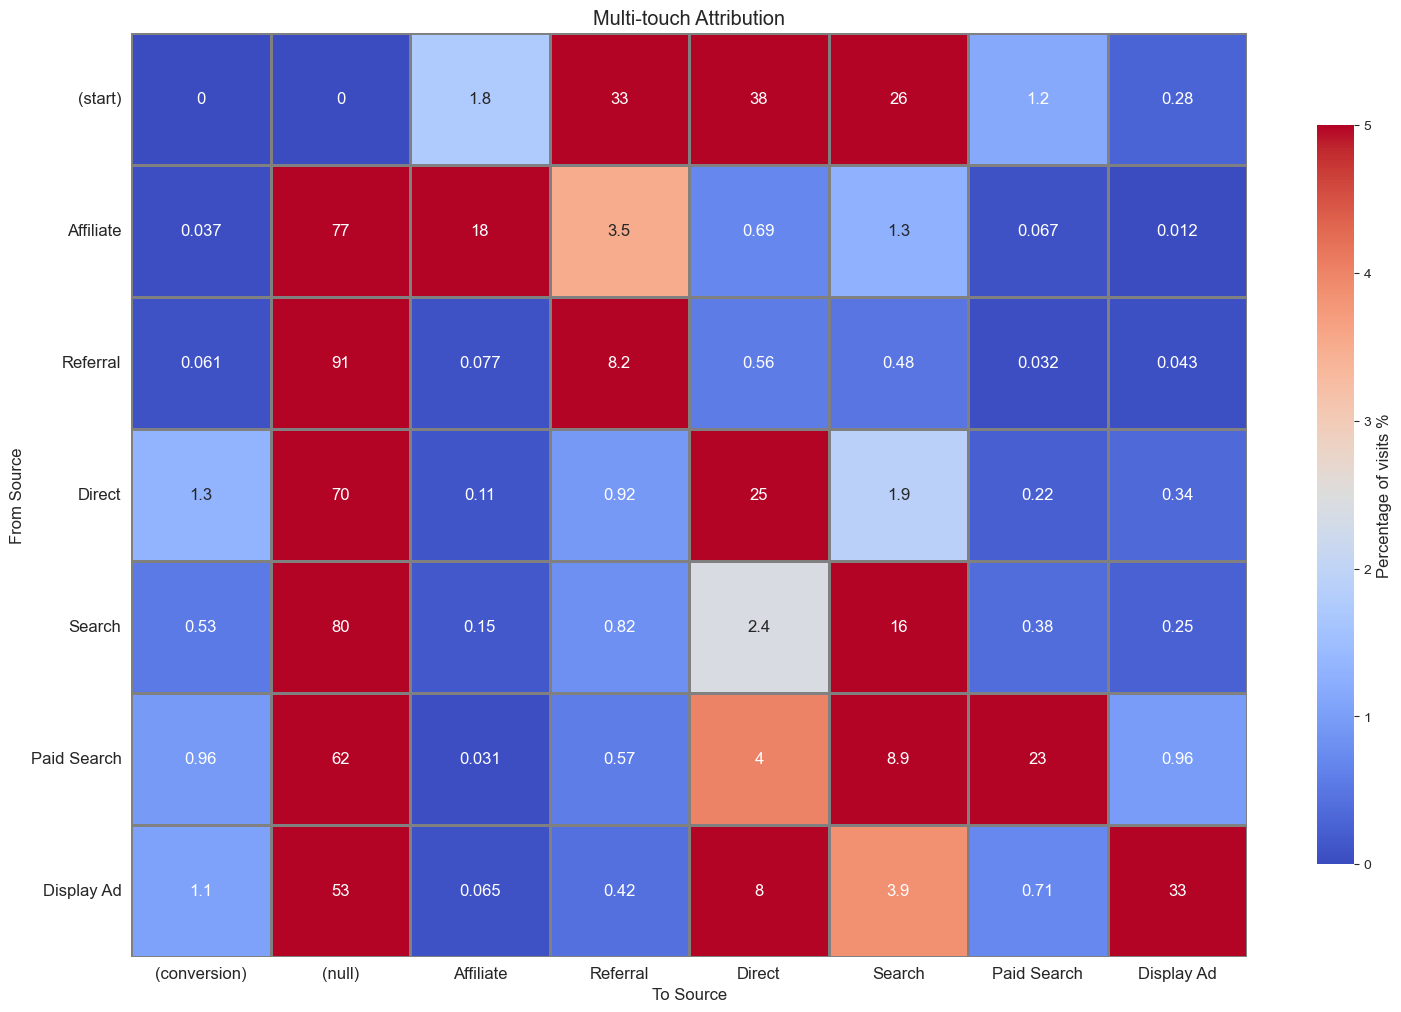

In [250]:
import matplotlib.style as style

#Heat map for transition probabilities in percentage in the data set
fig = plt.figure(figsize=(18, 12))
style.use('ggplot')
sns.set_style('whitegrid')

sns.heatmap(matrix * 100, 
            cmap=sns.color_palette("coolwarm", as_cmap=True),  # Use a diverging colormap
            vmin=0, vmax=5,  # Normalize colormap to range from 0 to 1
            annot=True, center= 2.5, annot_kws={'size': 12}, cbar=True,  # Ensure center at 0.5 for visual balance
            linewidths=1, linecolor='gray',  # Add gridlines between cells
            cbar_kws={"shrink": 0.8, "label": "Percentage of visits %"}  # Shrink the color bar a bit for better visibility
)
plt.title('Multi-touch Attribution')
plt.xlabel("To Source")
plt.ylabel("From Source")
plt.yticks(rotation=0, fontsize = 12)
plt.xticks(fontsize = 12)

# Save the figure
plt.savefig("transition_matrix.svg", dpi=300, bbox_inches='tight')